# Modelling

in this phase, we take our dataset with some extra features and  we'll try to focused on a supervised model to predict the variable **sold_quantity** that we found for each post.

In [1]:
import sys
sys.path.insert(0,'../..')

In [2]:
# Loading relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.stats import norm
import matplotlib.pyplot as plt
from utils import *

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold,cross_validate
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.gofplots import qqplot
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
import operator

## Loading data

At this point we gonna use two different sets, the first to train and validate the model and a second one to test the performance with new data.

In [3]:
# loading sets to train and test
#trainset
meli = pd.read_csv('../../data/03_processed/meli.csv',index_col=0)
#test
meli_test = pd.read_csv('../../data/03_processed/meli_test.csv',index_col=0)
meli.sample(3)

,price,available_quantity,sold_quantity,accepts_mercadopago,immediate_payment,cart_eligible,shipping_guaranteed,brand_verified,loyalty_discount_eligible,best_seller_candidate,dragged_visits,free_relist,discount_percentage,duplicated(Y/N)(1/0),freq_posts,new,not_specified,used
23960,1030.196770,1.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
40173,24.285586,1.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
39812,145.057151,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
print('Shape of train dataset', meli.shape)
print('Shape of test dataset ', meli_test.shape)

Shape of train dataset (48751, 18)
Shape of test dataset  (8635, 18)


## ¿What modelling approach to use?¿numerical or categorical?

Based on what was mentioned about the nature of variables, could be a good option to fit a **MVP model**, that capture some part of the nature of the variable  "*sold_quality*". two options are consider.

**Classification model**

-  Consider the target variable as a fully categorical or by making some "cuts" to create some bins or intervals(ranges) in that way each sold_quantity falls in a particular one. 

So the approach  to follow has two steps:
1. Create a **sold_quantity_range** variable, cutting  **sold_quantity** into intervals. 
2. Use a multiclass classification model to predict the interval or range in which the *sold_quantity* is expected to falls for a particular post.

**Regression model**
- We found that around 28 %(13611) of posts have sold_quantity less than 5. so we could take a numerical approach cuz we know that in those cases the reference is agree with the real sold_quantity.

## Classification model

In this case lets assume *sold_quantity* as fully categorical, so we are in **multiclass** problem with 72 classes!, so can be very difficult to get a good model performance. Two experiments  are address: 

- case 1: Without alter anything in the target variable, taking the 72 classes.
- case 2: making some cuts based on percentiles of the distribution of the target variable.

**Remark** Just for recall, we are gonna use two sets extracted in different time periods, one for train and validate the model, and the second one to test the models. 

### Case 1:

Lets consider *sold_quantity* with 72 different classes and try to compare the performance of some classification models like: *Random forest Classifier* and *Adaboost classifier*, both usually strong for classification tasks.

In [5]:
# best_classifier model compare those models 
best_classifier,report = best_classifier_model(meli)
# Report of metrics for model
report



************************************
best model selected: RandomForest
************************************


,test_accuracy,test_f1_weighted
Model,,
AdaBoost,0.317593,0.227684
RandomForest,0.366577,0.357848


As we expect the performance was so bad, so lets pass the model with the test data.

In [6]:
y_pred = best_classifier.predict(meli_test.drop(columns=['sold_quantity']))

In [7]:
accuracy_score(meli_test['sold_quantity'],y_pred)

0.3967573827446439

stills a bad result taking all categories as separated.

### Case 2: Creting "sold_quantity_range"

to make the cuts to this variable, is needed to analize the distribution of the variable.

In [8]:
meli['sold_quantity'].describe()

count    48751.000000
mean       131.780620
std        402.577867
min          0.000000
25%          3.000000
50%         25.000000
75%        150.000000
max      11189.000000
Name: sold_quantity, dtype: float64

the distribution of the *sold_quantity* variable show us that around 12187(25%) posts have a sold quantity lower than 3, and 25% upper than 150. So a initial option could be use quartiles to make the cuts.

###  Using percentiles.
Lets check the distribution of our dataset using the percentiles:0,25,50,75,90,100.

In [9]:
quartiles=[0,25,50,75,90,100]
np.percentile(meli['sold_quantity'], q=quartiles)

array([0.0000e+00, 3.0000e+00, 2.5000e+01, 1.5000e+02, 5.0000e+02,
       1.1189e+04])

their values looks good to start . So lets make the cuts using those percentiles.

In [10]:
# bins relative to quartiles
bins = [-0.1,3,25,50,150,500,11189]
meli_cut = add_cutting_func(meli,bins)
meli_test_cut= add_cutting_func(meli_test,bins)
meli_cut[['sold_quantity_range','interval']].head(3)

Number of classes(intervals):  6
Number of classes(intervals):  6


,sold_quantity_range,interval
0,4,"(150.0, 500.0]"
1,4,"(150.0, 500.0]"
2,4,"(150.0, 500.0]"


### Distribution of classes

the classes show an import imbalance for posts with sold_quantity values>500.So probably we should take a sample before to get more balance in classes.

In [11]:
pd.DataFrame(meli_cut['interval'].value_counts())

,interval
"(3.0, 25.0]",15050
"(-0.1, 3.0]",12600
"(150.0, 500.0]",11059
"(50.0, 150.0]",5003
"(25.0, 50.0]",4749
"(500.0, 11189.0]",290


In [12]:
# distribution of sold_quantity by the created sold_quantity_range
pd.DataFrame(meli_cut['sold_quantity_range'].value_counts())

,sold_quantity_range
1,15050
0,12600
4,11059
3,5003
2,4749
5,290


### Undersampling the dataset.

to handle the imbalance problem, we are goona take an undersamplig of majority classes, using the "undersampling function" created to get a relative more balanced dataset.

In [13]:
meli_sampled = create_undersampled_df(meli_cut)
meli_test_sampled = create_undersampled_df(meli_test_cut)
meli_sampled['sold_quantity_range'].value_counts()

0    8125
1    8125
4    8125
3    5003
2    4749
5     290
Name: sold_quantity_range, dtype: int64

In [14]:
# run the best_model function to compare classifiers
best_undersamp_clf,report = best_classifier_model(meli_sampled)
report



************************************
best model selected: RandomForest
************************************


,test_accuracy,test_f1_weighted
Model,,
AdaBoost,0.478572,0.355239
RandomForest,0.998925,0.998913


## Evaluate the model with "meli_test"

The meli_test as was mentioned, is an extra data set extracted from the MELI API to test the performance of the model.

In [15]:
# split the values of the meli test set, with values that model have not seen.
X_test=meli_test.drop(columns=['sold_quantity_range','interval'])
y_test = meli_test[['sold_quantity_range']]

In [16]:
print('X_test shape: ', X_test.shape)
print('y_test shape', y_test.shape)

X_test shape:  (8635, 18)
y_test shape (8635, 1)


In [17]:
# using the model to predict on the 
y_pred = best_undersamp_clf.predict(X_test)

In [18]:
# accuracy score
accuracy_score(y_test,y_pred)

0.999189345686161

The result looks so well. Clearly we reduce the number of classes from 72 to 6 so that can explain the performance, but we have to be careful because this can be a warning of *overfitting*. 

## Regression model

to address a regression approach we have to be clear about the assumptions we assume:
- **The variables are numerical**: in our case the values are numerical but tags variables refers to binary variables or *available quantity* whose values are categories. To try to avoid some of the noise generated with this assumption we use a *lasso regression* model at the beginning to delete those variables with zero significance.
- **Skip standardize data**: we saw that some tags doesn't look like good predictors, so we don't need a "balance" of the variables on the contrary we hope some of them be much more important that others. 


The pipeline proposed is as follow:
 1. Lasso model to delete variables with "zero" significance.
 2. run VIF(variance inflation factor) to avoid as possible multicollinearity problems.
 3. run an ols regression.

### Variables correlation


The correlation matrix shown below, evidence that there is no a strong correlation between  **Sold_quantity** with other variables the reasons are diverse, but in particular:

- The amount of data can be so small in contrast with the significant amount of categories.
- The variables are so generical to have a model with a good prediction power, so we could come back and find other data sourcers to create more meaningful variables. 


Text(0.5, 1.0, 'Heatmap of dataset')

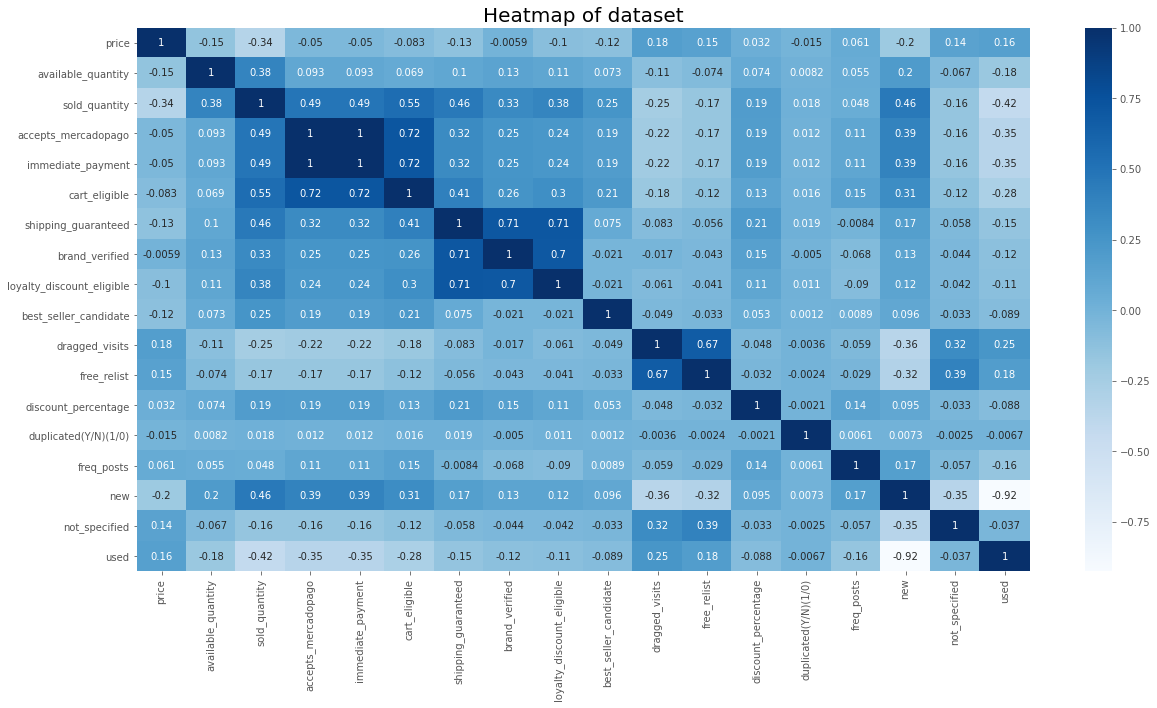

In [5]:
plt.rcParams['figure.figsize']=(20,10)
#corr = df.corr(method='pearson')
corr = meli.corr(method='spearman')
hm = sns.heatmap(corr,annot=True, cmap='Blues')
hm.set_title(label='Heatmap of dataset', fontsize=20)

we take a slice of the dataframe of cases with sold_quantity less than 5.

In [127]:
meli_reg = meli_sampled[meli_sampled['sold_quantity']<5]
meli_reg.reset_index(drop=True,inplace=True)

In [129]:
# Lasso model to supress some features
meli_reg_supr = lasso_model(meli_reg)

Lasso mae :  104.22708261591703
****************************************
supress the column: accepts_mercadopago 
supress the column: immediate_payment 
supress the column: cart_eligible 
supress the column: shipping_guaranteed 
supress the column: brand_verified 
supress the column: loyalty_discount_eligible 
supress the column: best_seller_candidate 
supress the column: dragged_visits 
supress the column: free_relist 
supress the column: discount_percentage 
supress the column: duplicated(Y/N)(1/0) 
supress the column: new 
supress the column: not_specified 
supress the column: used 


as we expect Lasso model lets us know what variables we should discard, because have a small significance.

### VIF computing

Remember VIF give us a tool to avoid multicollinearity problems.

In [130]:
VIF(meli_reg_supr)

Variance inflation factor for price: 1.0
Variance inflation factor for available_quantity: 1.0
Variance inflation factor for sold_quantity: 1.15
Variance inflation factor for freq_posts: 1.14


all the factors are below to the usual threshold 5. Some of then even have a value close to 1 showing that is reasonable to assume them **"independent"** as a linearl model expects.

## Linear model

In [131]:
X_reg = meli_reg_supr.drop(columns = ['sold_quantity'])
y = meli_reg_supr ['sold_quantity']

In [132]:
reg_lin = sm.OLS(y,sm.add_constant(X_reg)).fit()
# observando los resultados
reg_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sold_quantity   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     53.91
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           1.62e-34
Time:                        21:42:45   Log-Likelihood:                -14235.
No. Observations:                8651   AIC:                         2.848e+04
Df Residuals:                    8647   BIC:                         2.851e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7540      0.016     48.440      0.000       0.723       0.784
price              -6.499e-07   1.16e-07     -5.595      0.000   -8.78e-07   -4.22e-07
available_quantity  1.466e-05   9.94e-06      1.474      0.140   -4.83e-06    3.42e-05
freq_posts             0.0029      0.000     11.107      0.000       0.002       0.003
==============================================================================
Omnibus:                     1525.518   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2473.085
Skew:                           1.294   Prob(JB):                         0.00
Kurtosis:                       3.400   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Some conclusions of the linear model are:
- The r2 and adjustedr2 scores show a poor level of variance of the target variable explained by the model
- several variables p values are below 0.05, but the model says that available quantity is not statisticaly significant.
- the std is small so the values of coeficients are robust.
- the summary suggest multicollinearity problems. Lets check that with a residual analysis.

### Residuals Analysis

In [141]:
y_real = meli_reg_supr['sold_quantity']
y_pred = reg_lin.predict(sm.add_constant(X_reg))

In [151]:
# mae of the linear model
print('mae of linear model: ',mae(y_real,y_pred)*100)

mae of linear model:  102.96463780443925


The model have a poor mae. Lets verify all linear models assumptions  to get get an idea about the problem.

#### Normality of errors

One of the assumptios of a linear models is that the errors have a normal distribution with zero mean and same variance.

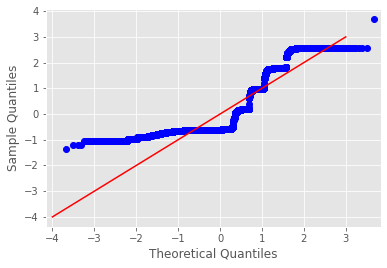

In [134]:
residuals=y_real-y_pred
qqplot(residuals,fit=True);
plt.plot([i for i in range(-4,4)],[i for i in range(-4,4)],c='r')

The plot evidence that the model assumption of normality distribution of residuals is not true in this case.

### Homoscedasticity

Refers to the assumption that the variance of errors are the same, meaning that $Cov(\epsilon_{1},\epsilon_{2})=0$

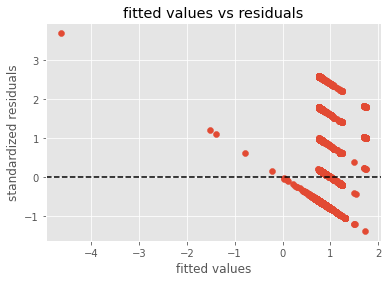

In [135]:
plt.scatter(y_pred,residuals/np.std(residuals))
plt.axhline(np.mean(residuals), linestyle='--',c='k')
plt.title('fitted values vs residuals')
plt.ylabel('standardized residuals')
plt.xlabel('fitted values');

The graph  before show us that we have problems of **Heteroscedasticity** because there is some "decrease patther", so the assumption of *homoscesdasticity* of a linearl model is not true.

### Leverage and influence.

As usual, we want to analyse and detect those observations than can affect our model. Some of them can be outliers, but others can have a significant *influence*.

In [136]:
influence = OLSInfluence(reg_lin);

<Figure size 1440x720 with 0 Axes>

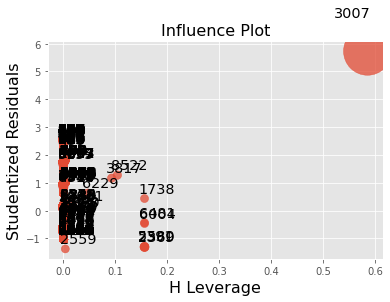

In [137]:
plt.figure(figsize=(20,10))
influence.plot_influence();

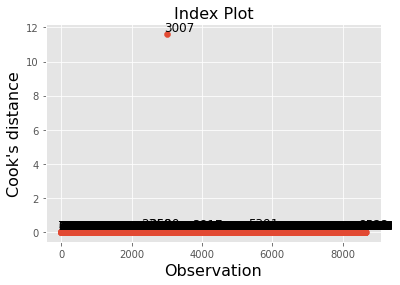

In [138]:
influence.plot_index();

Both graphs show us that one observation in particular(3007),have an importance influence in our model.Lets search for that record.

In [139]:
X_reg.iloc[3007,:]

price                 8.279298e+06
available_quantity    1.000000e+00
freq_posts            1.000000e+00
Name: 3007, dtype: float64

as graphs showed this post have a price extremely high so its influence on the model is remarkable.we can extend even more the analysis but we are gonna stop here.

## Some conclusions

- The model designed looks that could have an overfitting behavior and should be evaluated with more data.
- Clearly the features that we have rigth now probably are no the best to get a "universal" model as was tried, where we wanted to predict the sold_quantity for "multiple categories".
- a linear model usually give us a better understandig about significance of each variable, but at this point is not a good tool. Obviously we can explore a more general  and less restrictive approach like *generalized linear models*.


This is just the start to come back and look for other data sources and to find for a better understanding and look other approaches like:
- model just a group of categories
- model the target variable for a segment of sellers detected
- model other variables like number of posts published for  seller.


In general understand in a deeper way the seller and the costumer that used the platform.